# 02 · Classical ML Baselines

Benchmarks scikit-learn ensembles, kNN, XGBoost, and LightGBM on the FPF-cleaned dataset before comparing to neural networks.

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import joblib
import matplotlib.pyplot as plt

DATA_DIR = Path("data/processed")
TRAIN_PATH = DATA_DIR / "train_dataset.csv"
TEST_PATH = DATA_DIR / "test_dataset.csv"
MODEL_PATH = Path("models/classical_baseline.pkl")
RANDOM_STATE = 42
FEATURES = ["M", "S", "K", "phi1", "phi2", "Ec", "Pr", "eta"]
TARGETS = ["f3", "f5"]
plt.style.use("seaborn-v0_8")

## Load cleaned splits

In [2]:
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)
print(f"Train shape: {train_df.shape} | Test shape: {test_df.shape}")
train_df.head()

Train shape: (134, 10) | Test shape: (34, 10)


,M,S,K,phi1,phi2,Ec,Pr,eta,f3,f5
0,1.0,1.047198,1.0,0.02,0.01,0.3,204.0,0.666,-0.738286,-0.327482
1,1.0,1.047198,1.0,0.02,0.01,0.1,204.0,2.001,-1.275014,-0.482143
2,0.5,1.047198,1.0,0.02,0.01,0.5,204.0,0.666,-0.678774,-0.461762
3,1.0,1.047198,1.0,0.03,0.01,0.3,204.0,0.333,-0.621770,-0.423785
4,1.0,1.047198,1.0,0.02,0.01,0.1,204.0,1.332,-1.173023,-0.209804


## Feature/label construction

In [3]:
X_train = train_df[FEATURES].to_numpy(dtype=float)
y_train = train_df[TARGETS].to_numpy(dtype=float)
X_test = test_df[FEATURES].to_numpy(dtype=float)
y_test = test_df[TARGETS].to_numpy(dtype=float)
X_train[:3]

array([[1.00000000e+00, 1.04719755e+00, 1.00000000e+00, 2.00000000e-02,
        1.00000000e-02, 3.00000000e-01, 2.04000000e+02, 6.66000000e-01],
       [1.00000000e+00, 1.04719755e+00, 1.00000000e+00, 2.00000000e-02,
        1.00000000e-02, 1.00000000e-01, 2.04000000e+02, 2.00100000e+00],
       [5.00000000e-01, 1.04719755e+00, 1.00000000e+00, 2.00000000e-02,
        1.00000000e-02, 5.00000000e-01, 2.04000000e+02, 6.66000000e-01]])

## Deterministic baseline models

- **Random Forest / Gradient Boosting / KNN** from scikit-learn.
- **XGBoost (XGBRegressor)** adds second-order tree boosting, useful when magnetic/rotation parameters interact sharply.
- **LightGBM (LGBMRegressor)** captures similar nonlinearities with histogram-based trees and leaf-wise growth.

In [4]:
def make_pipeline(model):
    return Pipeline([
        ("scale", StandardScaler()),
        ("model", model),
    ])

pipelines = {
    "RandomForest": make_pipeline(
        RandomForestRegressor(
            n_estimators=400,
            random_state=RANDOM_STATE,
            n_jobs=-1,
        )
    ),
    "GradientBoosting": make_pipeline(
        MultiOutputRegressor(
            GradientBoostingRegressor(random_state=RANDOM_STATE)
        )
    ),
    "KNN": make_pipeline(
        MultiOutputRegressor(KNeighborsRegressor(n_neighbors=5))
    ),
    "XGBoost": make_pipeline(
        MultiOutputRegressor(
            XGBRegressor(
                n_estimators=600,
                learning_rate=0.05,
                max_depth=5,
                subsample=0.8,
                colsample_bytree=0.8,
                reg_lambda=1.0,
                random_state=RANDOM_STATE,
                n_jobs=-1,
            )
        )
    ),
    "LightGBM": make_pipeline(
        MultiOutputRegressor(
            LGBMRegressor(
                n_estimators=700,
                learning_rate=0.05,
                num_leaves=31,
                subsample=0.9,
                colsample_bytree=0.9,
                reg_lambda=0.5,
                random_state=RANDOM_STATE,
                n_jobs=-1,
            )
        )
    ),
}
list(pipelines.keys())

['RandomForest', 'GradientBoosting', 'KNN', 'XGBoost', 'LightGBM']

## Evaluation helper

In [5]:
import pandas as pd

def evaluate(pipeline, name):
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_test)
    metrics = {}
    for idx, target in enumerate(TARGETS):
        metrics[f"{target}_MAE"] = mean_absolute_error(y_test[:, idx], preds[:, idx])
        metrics[f"{target}_RMSE"] = mean_squared_error(y_test[:, idx], preds[:, idx]) ** 0.5
        metrics[f"{target}_R2"] = r2_score(y_test[:, idx], preds[:, idx])
    metrics["joint_MAE"] = mean_absolute_error(y_test, preds)
    metrics["joint_RMSE"] = np.sqrt(np.mean((y_test - preds) ** 2))
    return name, metrics, preds

results = []
predictions = {}
for name, pipe in pipelines.items():
    model_name, metric_dict, preds = evaluate(pipe, name)
    results.append({"model": model_name, **metric_dict})
    predictions[name] = preds

results_df = pd.DataFrame(results).sort_values("joint_RMSE")
results_df

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003380 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16
[LightGBM] [Info] Number of data points in the train set: 134, number of used features: 2
[LightGBM] [Info] Start training from score -0.622084
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\oumme\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\oumme\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


,model,f3_MAE,f3_RMSE,f3_R2,f5_MAE,f5_RMSE,f5_R2,joint_MAE,joint_RMSE
3,XGBoost,0.094659,0.158526,0.730798,0.325479,0.740274,0.892975,0.210069,0.535321
0,RandomForest,0.102896,0.170689,0.687901,0.310092,0.822477,0.867887,0.206494,0.593971
1,GradientBoosting,0.103836,0.159027,0.729092,0.385582,0.842681,0.861317,0.244709,0.606383
4,LightGBM,0.119459,0.174930,0.672200,0.914402,1.607381,0.495413,0.516931,1.143301
2,KNN,0.177325,0.248264,0.339753,1.174590,2.137496,0.107704,0.675958,1.521598


## Persist best baseline

In [6]:
best_model_name = results_df.iloc[0]["model"]
best_pipeline = pipelines[best_model_name]
best_pipeline.fit(np.vstack([X_train, X_test]), np.vstack([y_train, y_test]))
joblib.dump(best_pipeline, MODEL_PATH)
best_model_name, MODEL_PATH

('XGBoost', WindowsPath('models/classical_baseline.pkl'))

## Diagnostic plots

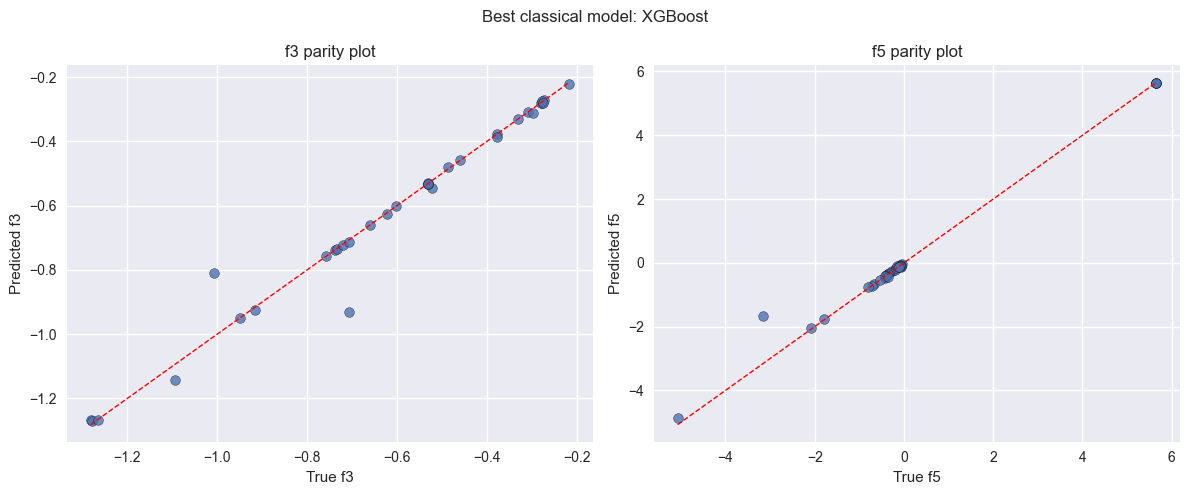

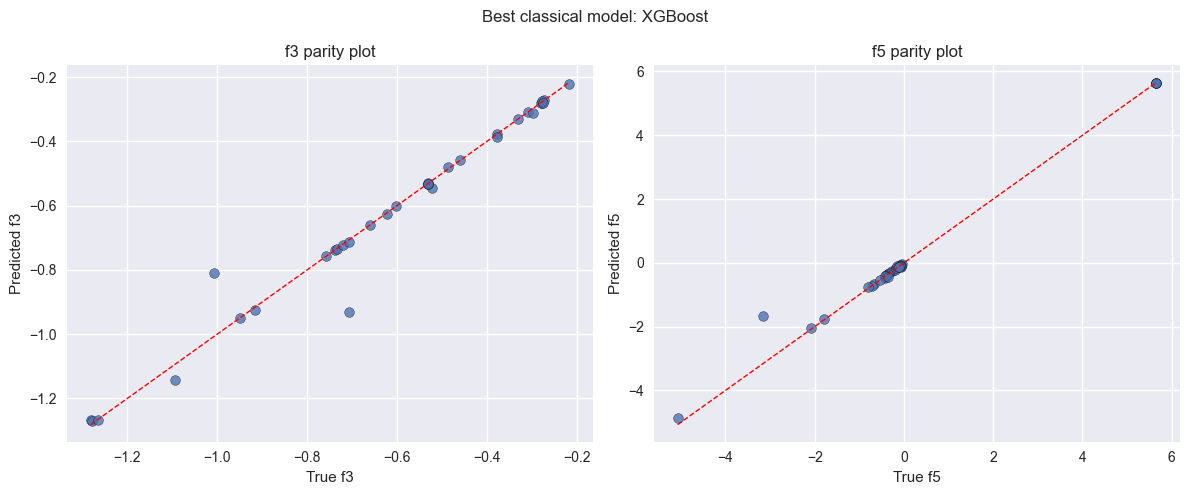

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
eval_preds = best_pipeline.predict(X_test)
for idx, target in enumerate(TARGETS):
    ax = axes[idx]
    ax.scatter(y_test[:, idx], eval_preds[:, idx], alpha=0.8, edgecolor="k")
    diag = np.linspace(y_test[:, idx].min(), y_test[:, idx].max(), 100)
    ax.plot(diag, diag, "r--", linewidth=1)
    ax.set_xlabel(f"True {target}")
    ax.set_ylabel(f"Predicted {target}")
    ax.set_title(f"{target} parity plot")
fig.suptitle(f"Best classical model: {best_model_name}")
fig.tight_layout()
fig